## Imports

Note: written for `swyft==0.4.5`

In [1]:
import swyft
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.interpolate import interp1d
import tqdm

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simulator

Implementation of a 'fake' LISA simulator that loads pre-calculated noise curves in the A, E, and T channels normalised by the response. Normalising by the response allows the signal model to be very simple (just a power law) without computing any response matrices.

- **Signal Model:** $P_s(f | \alpha, \gamma) = 10^{\alpha} (f / f_\star)^{\gamma} \times [3 (H_0 / h)^2 / (4 \pi^2 f^3)]$
- **Noise Model:** $P_n(f | A, P) = A^2 P_\mathrm{TM}(f | A = 1) + P^2 P_\mathrm{OMS}(f | P = 1)$ (Note: the $P_{\mathrm{TM}, \mathrm{OMS}})(f | ...)$ are the (normalised) quantities that are loaded.)
- **Parameter vector:** $z = (\alpha, \gamma, \mathrm{TM}, \mathrm{OMS})$
- **Frequency Grid:** Goal is to take $f_\mathrm{min} = 3 \times 10^{-5} \,\mathrm{Hz}$, $f_\mathrm{max} = 3 \times 10^{-5} \,\mathrm{Hz}$ and $\Delta f = 10^{-6} \, \mathrm{Hz}$. This corresponds to about `npts = 5e5` below, so taking that as the benchmark case.
- **Priors:** Again, ideally start with priors: $\alpha \in [-20, -5]$, $\gamma \in [-10, 10]$, $A \in [0, 6]$, $P \in [0, 30]$. This induces a wide variance in the order of magnitude of the signal vs the noise, this is a problem that needs to be dealt with.
- **Fiducial Model:** Take $(\alpha, \gamma, A, P) = (-11, 0, 3, 15)$ as a fiducial observation that we want to perform well on.
- **Overall Rescaling:** Include an overall rescaling of $10^{30}$ on the PSD data just for numerical stability.
- **Data Generation:** Linear data is generated as \sqrt{2} d_{n,s}(f) = \mathcal{N}(0, \sqrt{P_{n, s}(f)}) + j \mathcal{N}(0, \sqrt{P(f)}). Then, the quadratic data is generated as $|d(f)|^2 = |d_n(f) + d_s(f)|^2$. Note: The output of the simulator is **squared** data, not linear data. 

In [96]:
class FakeLISA(swyft.Simulator):
    def __init__(
        self,
        npts=5e5,
        ngrid=1000,
        bounds=np.array([[-13.0, -8.0], [-5.0, 5.0], [0.0, 6.0], [0.0, 30.0]]),
    ):
        super().__init__()
        self.f = np.geomspace(3e-5, 5e-1, npts) #TODO: Change back to arange  # Generate fixed frequency array
        self.Hubble_over_h = 3.24e-18  # Hubble constant rescaling to strain
        self.npts = npts  # Number of points to sample in logspace
        self.nparams = 4
        self.ngrid = ngrid
        self.bounds = bounds  # Prior bounds on [alpha, gamma, A, P]
        self.overall_rescaling = 1e30  # Overall rescaling for numerical stability
        self.setup_noise_curves()  # Setup the fixed noise curves on the fixed frequency array
        self.setup_coarse_graining()
        self.transform_samples = swyft.to_numpy32

    def setup_noise_curves(self):
        """
        Load the LISA noise curves and interpolate them on the fixed frequency array
        Setup:
            self.TM_strain_AE: Noise curve for the TM nosie in the AA and EE channels
            self.OMS_strain_AE: Noise curve for the OMS noise in the AE and EA channels
            self.TM_strain_TT: Noise curve for the TM noise in the TT channel
            self.OMS_strain_TT: Noise curve for the OMS noise in the TT channel
        """
        TM_data = np.load("lisa_data_TM.npy")
        OMS_data = np.load("lisa_data_OMS.npy")

        TM_interpolator_AE = interp1d(
            np.log(TM_data[:, 0]), np.log(TM_data[:, 1]), fill_value="extrapolate"
        )
        OMS_interpolator_AE = interp1d(
            np.log(OMS_data[:, 0]), np.log(OMS_data[:, 1]), fill_value="extrapolate"
        )
        self.TM_strain_AE = lambda f: np.exp(TM_interpolator_AE(np.log(f)))
        self.OMS_strain_AE = lambda f: np.exp(OMS_interpolator_AE(np.log(f)))
        self.TM_noise_AA = self.TM_strain_AE(self.f)
        self.OMS_noise_AA = self.OMS_strain_AE(self.f)

        self.TM_noise_EE = self.TM_strain_AE(self.f)
        self.OMS_noise_EE = self.OMS_strain_AE(self.f)

        TM_interpolator_TT = interp1d(
            np.log(TM_data[:, 0]), np.log(TM_data[:, 2]), fill_value="extrapolate"
        )
        OMS_interpolator_TT = interp1d(
            np.log(OMS_data[:, 0]), np.log(OMS_data[:, 2]), fill_value="extrapolate"
        )
        self.TM_strain_TT = lambda f: np.exp(TM_interpolator_TT(np.log(f)))
        self.OMS_strain_TT = lambda f: np.exp(OMS_interpolator_TT(np.log(f)))
        self.TM_noise_TT = self.TM_strain_TT(self.f)
        self.OMS_noise_TT = self.OMS_strain_TT(self.f)

        self.TM_noise = np.vstack(
            [self.TM_noise_AA, self.TM_noise_AA, self.TM_noise_TT]
        )
        self.OMS_noise = np.vstack(
            [self.OMS_noise_AA, self.OMS_noise_EE, self.OMS_noise_TT]
        )
    
    def setup_coarse_graining(self):
        bin_edges = np.geomspace(self.f[0], self.f[-1], self.ngrid + 1)
        self.bins_array = []
        self.mask_array = []
        self.weights_array = []
        self.coarse_grained_f = []
        for i in range(1,self.ngrid + 1):
            top_of_bin = bin_edges[i]
            bottom_of_bin = bin_edges[i-1]
            mask = (self.f >= bottom_of_bin) & (self.f < top_of_bin)
            freqs_to_add = self.f[mask]
            self.bins_array.append(freqs_to_add)
            self.mask_array.append(mask)
            #weights = np.einsum('i,ij->ij', 1/np.sum(1/self.TM_noise[:, mask], axis=-1), 1/self.TM_noise[:, mask])
            weights = np.ones((3, len(freqs_to_add))) / len(freqs_to_add)
            self.weights_array.append(weights)
            self.coarse_grained_f.append(np.sum(np.einsum('ij,j->ij', weights, freqs_to_add), axis=-1))
        self.coarse_grained_f = np.array(self.coarse_grained_f)

    def get_z(self):
        """
        Sample the parameters from the prior boudns. Ordering: [alpha, gamma, A, P]
        """
        return np.random.uniform(self.bounds[:, 0], self.bounds[:, 1])

    def get_noise_template(self, z):
        """
        Compute the noise template for the given parameters, A = z[2], P = z[3]
        Noise template: A^2 * TM_noise + P^2 * OMS_noise
        """
        return self.overall_rescaling * (
            z[2] ** 2 * self.TM_noise + z[3] ** 2 * self.OMS_noise
        )

    def sgwb_template(self, f, z_sgwb):
        """
        Compute the SGWB template for the given parameters, \alpha = z_sgwb[0],
        \gamma = z_sgwb[1].
        Signal Template:
            (1/strain_conversion) 10^{\alpha} * (f / \sqrt{f_{\text{min}} f_{\text{max}}})^{\gamma}
        """
        conversion = (
            4 * np.pi**2 * f**3 / 3 / self.Hubble_over_h**2
        )  # Convert to strain units
        return 10 ** z_sgwb[0] * (f / np.sqrt(f[0] * f[-1])) ** z_sgwb[1] / conversion

    def get_signal_template(self, z):
        """
        Compute the SGWB template for the given parameters, \alpha = z[0], \gamma = z[1].
        """
        return self.overall_rescaling * self.sgwb_template(self.f, z[:2])

    def get_quadratic_data(self, temp_noise, temp_signal):
        """
        Generate the quadratic data for the given noise and signal templates.
        Data: |noise|^2 + |signal|^2 (shape = (3, npts))
        noise: Gaussian noise with variance temp_noise (3, npts)
        signal: Gaussian noise with variance temp_signal (3, npts)
        """
        noise_data = (
            1
            / np.sqrt(2)
            * (
                np.random.normal(0.0, np.sqrt(temp_noise))
                + 1j * np.random.normal(0.0, np.sqrt(temp_noise))
            )
        )
        signal_data = (
            1
            / np.sqrt(2)
            * (
                np.random.normal(0.0, np.sqrt(temp_signal), size=(3, len(self.f)))
                + 1j
                * np.random.normal(0.0, np.sqrt(temp_signal), size=(3, len(self.f)))
            )
        )
        return np.real((noise_data + signal_data) * np.conj(noise_data + signal_data))
    
    def get_coarse_grained_data(self, quadratic_data):
        out = np.zeros((3, self.ngrid))
        for idx in range(self.ngrid):
            mask, weights = self.mask_array[idx], self.weights_array[idx]
            out[:, idx]= np.sum(np.einsum('ij,ij->ij', weights, quadratic_data[:, mask]), axis=-1)
        return out


    def build(self, graph):
        z = graph.node("z", self.get_z)
        temp_noise = graph.node("temp_noise", self.get_noise_template, z)
        temp_signal = graph.node("temp_signal", self.get_signal_template, z)
        quadratic_data = graph.node(
            "quadratic_data", self.get_quadratic_data, temp_noise, temp_signal
        )
        coarse_grained_data = graph.node("coarse_grained_data", self.get_coarse_grained_data, quadratic_data)

In [100]:
lisa_sim = FakeLISA(npts=5e5, ngrid=1000)

In [101]:
lisa_sim.weights_array

[array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=float64),
 array([[1.],
        [1.],
        [1.]]),
 array([], shape=(3, 0), dtype=float64),
 array([], shape=(3, 0), dtype=fl

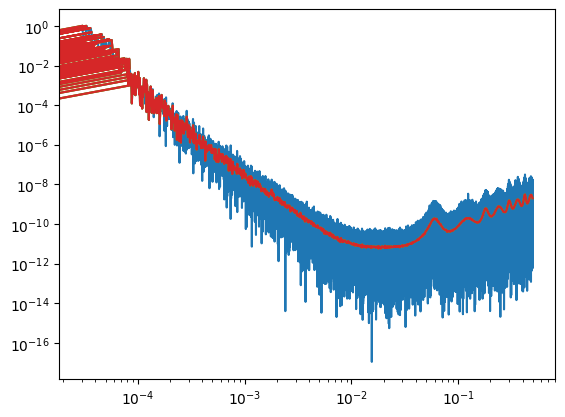

: 

In [102]:
sample = lisa_sim.sample()
plt.loglog(lisa_sim.f, sample["quadratic_data"][0], label="Data")
plt.loglog(lisa_sim.coarse_grained_f, sample["coarse_grained_data"][0], label="Noise")


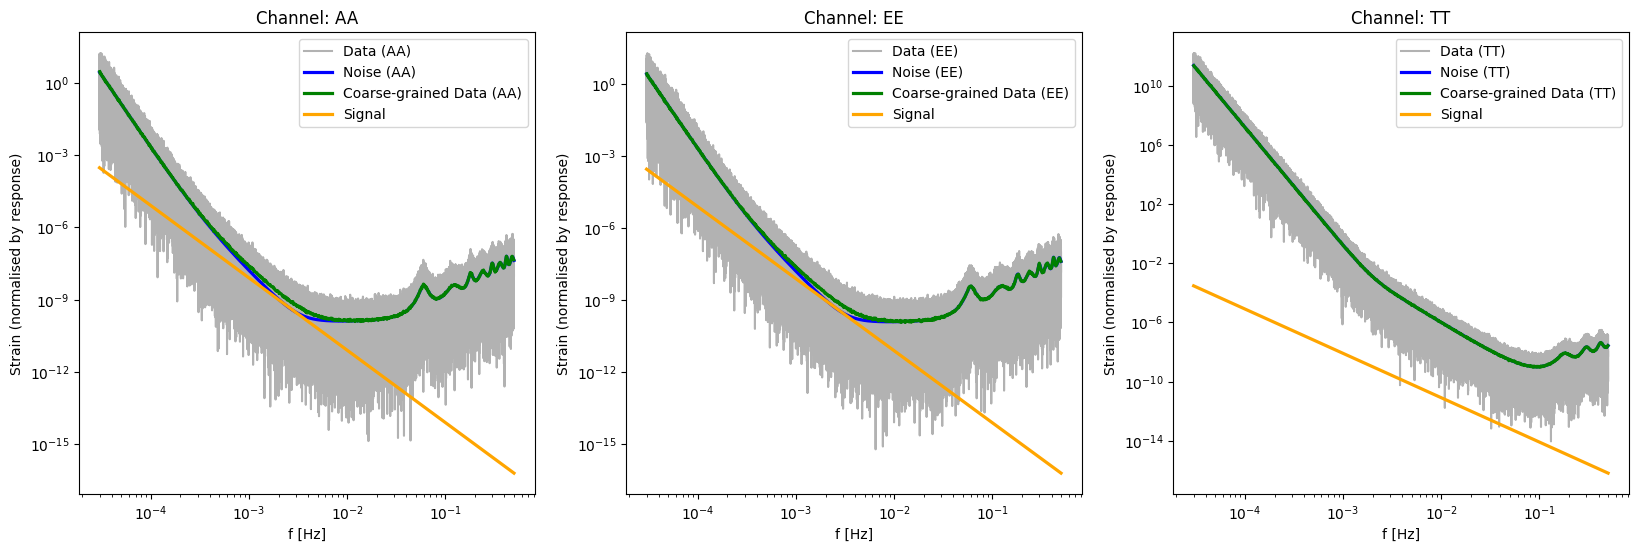

In [46]:
nfreq_pts = 5e5
sim = FakeLISA(npts=int(nfreq_pts))
sample = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3.0, 15.0])})

labels = ["AA", "EE", "TT"]
fig = plt.figure(figsize=(20, 6))
for i in range(3):
    ax = fig.add_subplot(1, 3, i + 1)
    plt.loglog(
        sim.f,
        sample["quadratic_data"][i, :],
        c="k",
        label=f"Data ({labels[i]})",
        alpha=0.3,
    )
    plt.loglog(
        sim.f,
        sample["temp_noise"][i, :],
        c="blue",
        label=f"Noise ({labels[i]})",
        lw=2.3,
    )
    plt.loglog(
        sim.coarse_grained_f[:, i],
        sample["coarse_grained_data"][i, :],
        c="green",
        label=f"Coarse-grained Data ({labels[i]})",
        lw=2.3,
    )
    plt.loglog(sim.f, sample["temp_signal"], c="orange", label="Signal", lw=2.3)
    plt.xlabel("f [Hz]")
    plt.ylabel("Strain (normalised by response)")
    plt.title(f"Channel: {labels[i]}")
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")

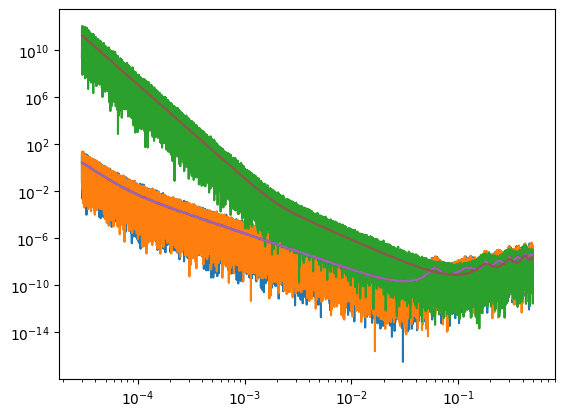

In [47]:
sample = sim.sample()
plt.loglog(sim.f, sample["quadratic_data"].T)
plt.loglog(sim.coarse_grained_f, sample["coarse_grained_data"].T)

## Data Generation

Pre-generate a set of $N = 100000$ simulations from the model

In [48]:
shapes, dtypes = sim.get_shapes_and_dtypes()
print("shapes:", shapes)
print("dtypes:", dtypes)
shapes.pop('temp_noise')
shapes.pop('temp_signal')
shapes.pop('quadratic_data')
dtypes.pop('temp_noise')
dtypes.pop('temp_signal')
dtypes.pop('quadratic_data')

shapes: {'z': (4,), 'temp_noise': (3, 500000), 'temp_signal': (500000,), 'quadratic_data': (3, 500000), 'coarse_grained_data': (3, 1000)}
dtypes: {'z': dtype('float32'), 'temp_noise': dtype('float32'), 'temp_signal': dtype('float32'), 'quadratic_data': dtype('float32'), 'coarse_grained_data': dtype('float32')}


dtype('float32')

In [49]:
store = swyft.ZarrStore(f"./store_frequencies_{nfreq_pts}")
store.init(N=5000, chunk_size=64, shapes=shapes, dtypes=dtypes)

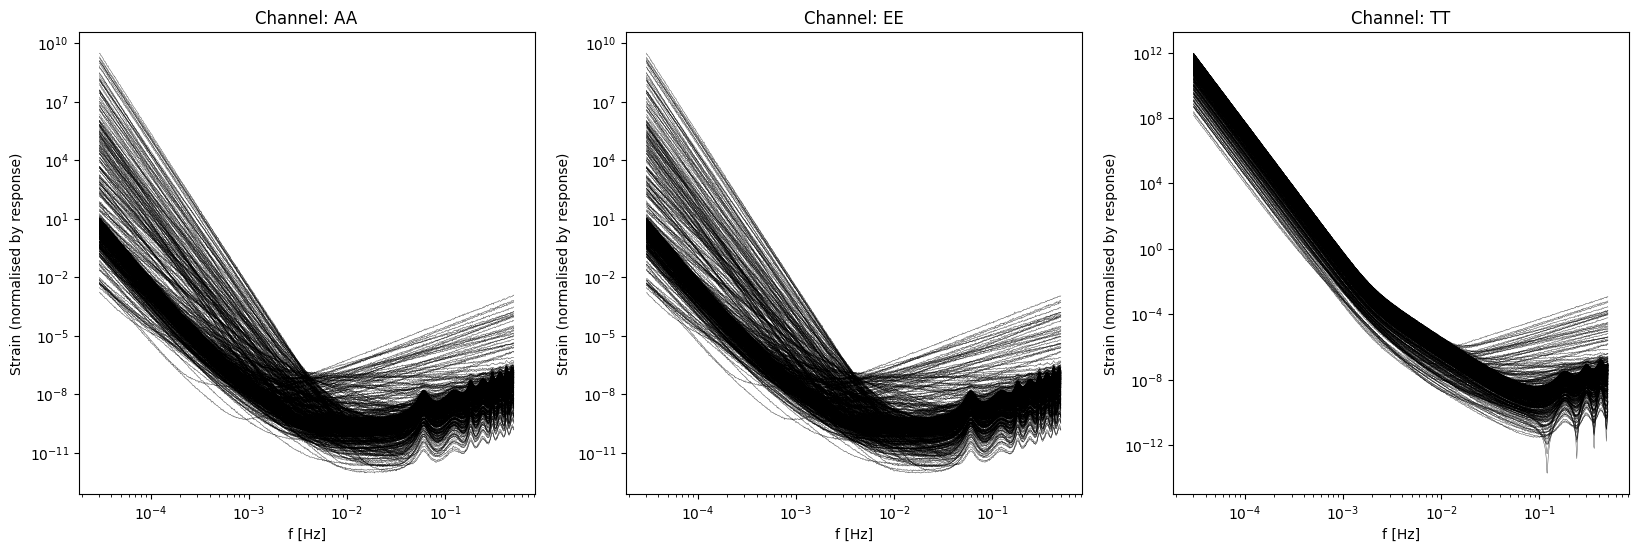

In [63]:
fig = plt.figure(figsize=(20, 6))
for i in range(512):
    for j in range(3):
        ax = plt.subplot(1, 3, j + 1)
        plt.loglog(sim.coarse_grained_f, store[i]['coarse_grained_data'][j, :], c="k", alpha=0.3, lw=0.3)
        plt.xlabel("f [Hz]")
        plt.ylabel("Strain (normalised by response)")
        plt.title(f"Channel: {labels[j]}")

In [50]:
print("Number of simulations required:", store.sims_required)
if store.sims_required > 0:
    import ray
    ray.init()
    store_object = ray.put(store)
    shapes_object = ray.put(shapes)
    dtypes_object = ray.put(dtypes)

    @ray.remote
    class ParallelSimulator:
        def __init__(self):
            self.sim = FakeLISA(npts=int(nfreq_pts))
            # self.store = swyft.ZarrStore(f"./store_frequencies_{nfreq_pts}")
            # self.shapes, self.dtypes = self.sim.get_shapes_and_dtypes()
        
        def simulate(self, batch_size):
            ray.get(store_object).simulate(self.sim, batch_size=batch_size)

    nthreads = 6
    threads = [ParallelSimulator.remote() for _ in range(nthreads)]

    for idx in range(nthreads):
        threads[idx].simulate.remote(batch_size=64)

Number of simulations required: 5000


2024-04-03 16:16:50,106	INFO worker.py:1752 -- Started a local Ray instance.


 20%|██        | 13/64 [00:20<01:13,  1.45s/it]


In [68]:
store.sims_required

0

In [69]:
# Call this cell to shutdown the data generation step
ray.shutdown()

 22%|██▏       | 14/64 [00:22<01:11,  1.43s/it] [repeated 6x across cluster]


## Network Training and Inference

The example below is just one idea of how things could be constructed, normalising by the variance only of a fiducial noise template and then following the score methodology. But this notebook is meant to be a place to try lots of things!

sigmas shape: (3, 1000)


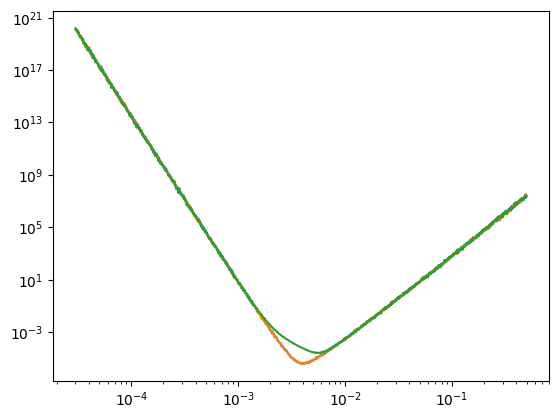

In [24]:
sigmas = np.mean(store['coarse_grained_data'], axis=(0,))
plt.loglog(sim.coarse_grained_f, sigmas.T)
print("sigmas shape:", sigmas.shape)

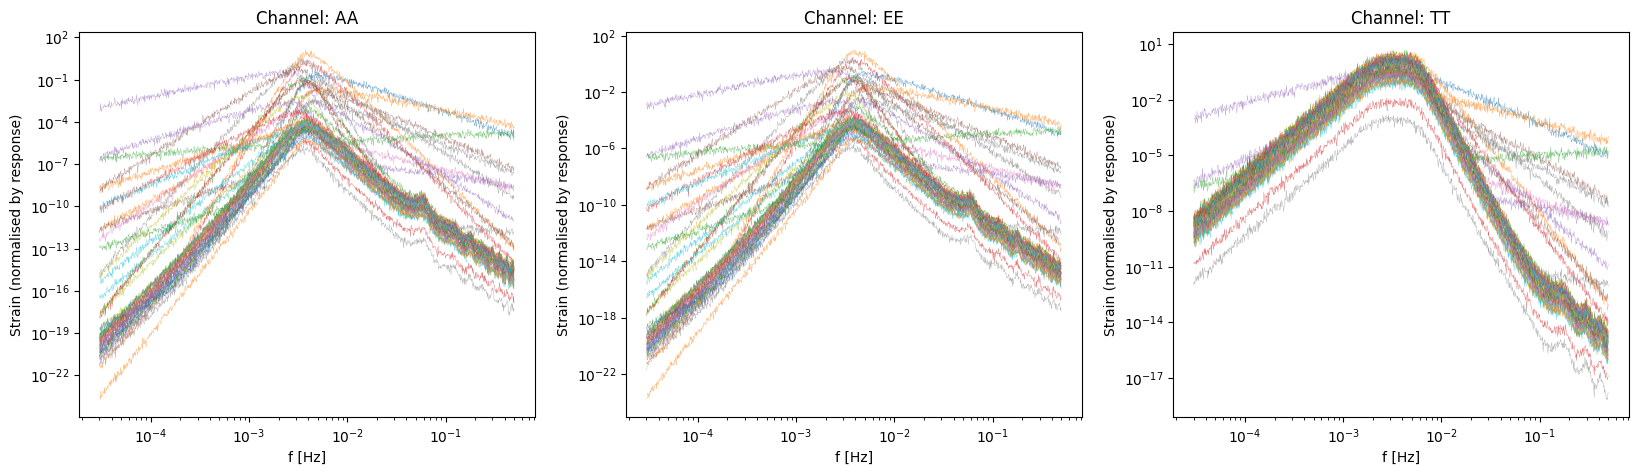

In [29]:
fig = plt.figure(figsize=(20, 5))
labels = ["AA", "EE", "TT"]
for _ in range(50):
    sample = sim.sample()
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.loglog(
            sim.coarse_grained_f[:, i],
            sample["coarse_grained_data"][i, :] / sigmas[i, :],
            alpha=0.9,
            lw=0.2,
        )
        plt.xlabel("f [Hz]")
        plt.ylabel("Strain (normalised by response)")
        plt.title(f"Channel: {labels[i]}")

In [70]:
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel


class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, est_sigmas=None, sim=None):
        super().__init__()
        self.sigmas = est_sigmas
        self.sim = sim
        self.learning_rate = 1e-4
        self.num_feat_param = 3  # Number of channels
        self.num_params = sim.nparams
        self.npts = sim.coarse_grained_f.shape[0]
        self.nl_AA = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT = OnlineStandardizingLayer(shape=(self.npts,))
        self.resnet = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=4,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.fc_AA = nn.Linear(self.npts, sim.nparams)
        self.fc_EE = nn.Linear(self.npts, sim.nparams)
        self.fc_TT = nn.Linear(self.npts, sim.nparams)
        self.marginals = self.get_marginals(sim.nparams)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            num_features=self.num_feat_param,
            num_params=self.num_params,
            varnames="z",
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            num_features=2 * self.num_feat_param,
            marginals=self.marginals,
            varnames="z",
        )

    def forward(self, A, B):
        log_data = torch.log(A["coarse_grained_data"])
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])

        full_data = torch.stack([norm_AA, norm_EE, norm_TT], dim=-2)

        compression = self.resnet(full_data)
        s1 = compression.reshape(
            -1, self.num_params, self.num_feat_param
        )  # (batch, num_params, num_feat_param)
        s2 = torch.stack(
            [torch.cat([s1[:, i, :], s1[:, j, :]], dim=-1) for i, j in self.marginals],
            dim=1,
        )
        lrs1d = self.lrs1d(s1, B["z"])
        lrs2d = self.lrs2d(s2, B["z"])
        return lrs1d, lrs2d

    # def forward(self, A, B):
    #     # score_input_AA = self.nl_AA(
    #     #     torch.tensor(A["coarse_grained_data"][..., 0, :] / self.sigmas[0, :] ** 2)
    #     # )
    #     # score_input_EE = self.nl_EE(
    #     #     torch.tensor(A["quadratic_data"][..., 1, :].cpu() / self.sigmas[1, :] ** 2)
    #     # )
    #     # score_input_TT = self.nl_TT(
    #     #     torch.tensor(A["quadratic_data"][..., 2, :].cpu() / self.sigmas[2, :] ** 2)
    #     # )
    #     score_input_AA = self.nl_AA(
    #         torch.log(A["coarse_grained_data"][..., 0, :])
    #     )
    #     score_input_EE = self.nl_AA(
    #         torch.log(A["coarse_grained_data"][..., 1, :])
    #     )
    #     score_input_TT = self.nl_AA(
    #         torch.log(A["coarse_grained_data"][..., 2, :])
    #     )
    #     score_compression_AA = self.fc_AA(score_input_AA)
    #     score_compression_EE = self.fc_EE(score_input_EE)
    #     score_compression_TT = self.fc_TT(score_input_TT)
    #     score_compression = torch.stack(
    #         [score_compression_AA, score_compression_EE, score_compression_TT], dim=-2
    #     )
    #     s1 = score_compression.reshape(
    #         -1, self.num_params, self.num_feat_param
    #     )  # (batch, num_params, num_feat_param)
    #     s2 = torch.stack(
    #         [torch.cat([s1[:, i, :], s1[:, j, :]], dim=-1) for i, j in self.marginals],
    #         dim=1,
    #     )
    #     lrs1d = self.lrs1d(s1, B["z"])
    #     lrs2d = self.lrs2d(s2, B["z"])
    #     return lrs1d, lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [71]:
trainer = swyft.SwyftTrainer(accelerator="cpu", max_epochs=100)
dm = swyft.SwyftDataModule(store, batch_size=256)
network = InferenceNetwork(sim=sim)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [72]:
trainer.fit(network, dm)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name   | Type                     | Params
----------------------------------------------------
0 | nl_AA  | OnlineStandardizingLayer | 0     
1 | nl_EE  | OnlineStandardizingLayer | 0     
2 | nl_TT  | OnlineStandardizingLayer | 0     
3 | resnet | ResidualNetWithChannel   | 295 K 
4 | fc_AA  | Linear                   | 4.0 K 
5 | fc_EE  | Linear                   | 4.0 K 
6 | fc_TT  | Linear                   | 4.0 K 
7 | lrs1d  | LogRatioEstimator_1dim   | 70.1 K
8 | lrs2d  | LogRatioEstimator_Ndim   | 106 K 
----------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.939     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 29: : 20it [00:07,  2.81it/s, loss=-10.7, v_num=4, val_loss=-11.0] 
Reloading best model: /Users/james/Code/public_releases/saqqara/examples/fake_lisa/lightning_logs/version_4/checkpoints/epoch=24-step=400.ckpt


In [76]:
prior_samples = sim.sample(targets=["z"], N=10000)
observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3.0, 15.0])})
lrs = trainer.infer(network, observation, prior_samples)

100%|██████████| 10000/10000 [00:00<00:00, 140976.00it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0:  10%|█         | 1/10 [00:00<00:01,  6.60it/s]

/Users/james/Code/mambaforge/envs/saqqara-3.11/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


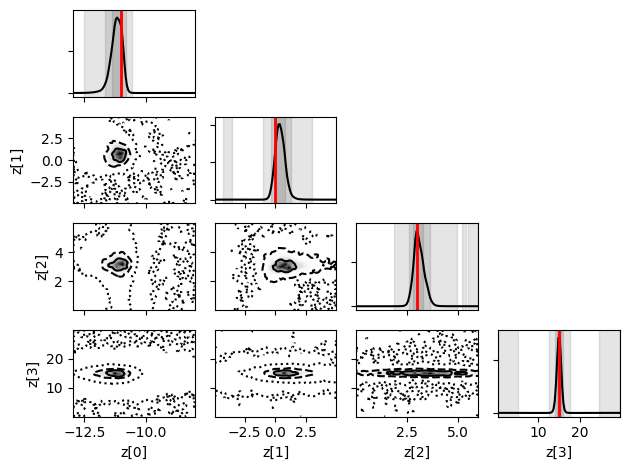

In [83]:
swyft.plot_corner(
            lrs,
            parnames=[
                "z[0]",
                "z[1]",
                "z[2]",
                "z[3]",
            ],
            smooth=1.2,
        );
truths = [-11.0, 0.0, 3.0, 15.0]
for i in range(4):
    ax = plt.subplot(4, 4, 4 * i + i + 1)
    plt.axvline(truths[i], c="r", lw=2)


  0%|          | 0/25 [00:00<?, ?it/s]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


  4%|▍         | 1/25 [00:02<01:05,  2.72s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]

  8%|▊         | 2/25 [00:05<00:59,  2.59s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]

 12%|█▏        | 3/25 [00:07<00:56,  2.56s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]

 16%|█▌        | 4/25 [00:10<00:53,  2.54s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.18it/s]

 20%|██        | 5/25 [00:12<00:50,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]

 24%|██▍       | 6/25 [00:15<00:48,  2.54s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]

 28%|██▊       | 7/25 [00:17<00:45,  2.55s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]

 32%|███▏      | 8/25 [00:20<00:43,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]

 36%|███▌      | 9/25 [00:22<00:40,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]

 40%|████      | 10/25 [00:25<00:37,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]

 44%|████▍     | 11/25 [00:27<00:35,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]

 48%|████▊     | 12/25 [00:30<00:32,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]

 52%|█████▏    | 13/25 [00:32<00:30,  2.51s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]

 56%|█████▌    | 14/25 [00:35<00:27,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.03it/s]

 60%|██████    | 15/25 [00:37<00:25,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.16it/s]

 64%|██████▍   | 16/25 [00:40<00:22,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]

 68%|██████▊   | 17/25 [00:43<00:20,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]

 72%|███████▏  | 18/25 [00:45<00:17,  2.54s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.08it/s]

 76%|███████▌  | 19/25 [00:48<00:15,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.77it/s]

 80%|████████  | 20/25 [00:50<00:12,  2.54s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]

 84%|████████▍ | 21/25 [00:53<00:10,  2.52s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  7.78it/s]

 88%|████████▊ | 22/25 [00:55<00:07,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]

 92%|█████████▏| 23/25 [00:58<00:05,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]

 96%|█████████▌| 24/25 [01:00<00:02,  2.54s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


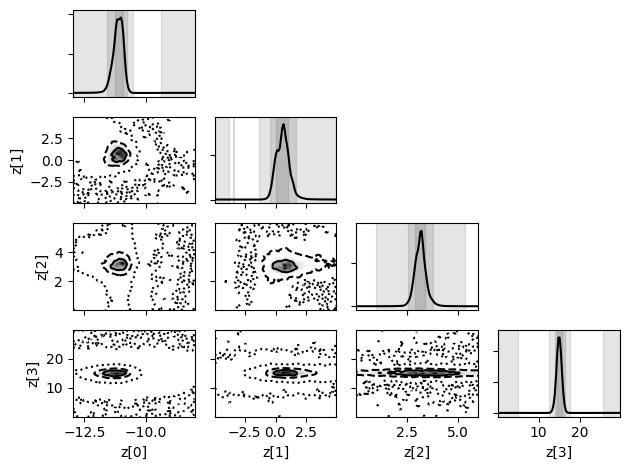

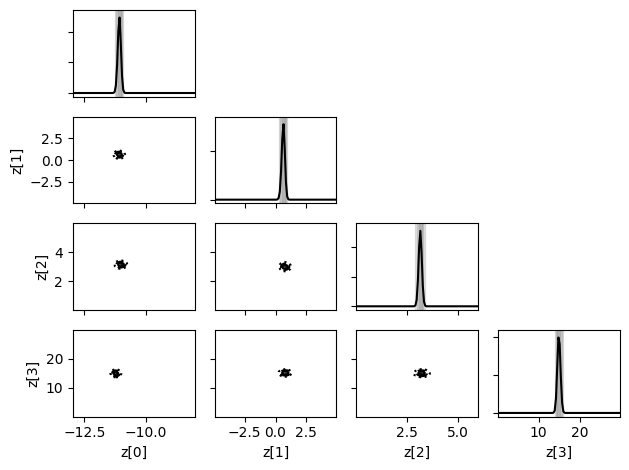

In [82]:
lrs_total = swyft.LogRatioSamples(
    logratios=torch.zeros((10000, 6)),
    params=torch.zeros((10000, 6, 2)),
    parnames=[
        ["z[0]", "z[1]"],
        ["z[0]", "z[2]"],
        ["z[0]", "z[3]"],
        ["z[1]", "z[2]"],
        ["z[1]", "z[3]"],
        ["z[2]", "z[3]"],
    ],
)
prior_samples = sim.sample(targets=["z"], N=10000)
for i in tqdm.tqdm(range(25)):
    observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3.0, 15.0])})
    # with torch.no_grad():
    #     network.eval()
    #     A = {"coarse_grained_data": torch.tensor(observation["coarse_grained_data"])}
    #     B = {"z": torch.tensor(prior_samples["z"])}
    #     lrs_out = network(A, B)
    lrs_out = trainer.infer(network, observation, prior_samples)
    lrs_total.logratios += lrs_out[1].logratios
    lrs_total.params = lrs_out[1].params

    if i == 0 or i == 24:
        swyft.plot_corner(
            lrs_total,
            parnames=[
                "z[0]",
                "z[1]",
                "z[2]",
                "z[3]",
            ],
            smooth=1.2,
        )